In [49]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from hdbscan import HDBSCAN
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json
import random

In [50]:
import sys
sys.path.insert(0, '../src/torch_helpers')

from autoencoder import AutoEncoder, AETrainer
from encoding_classifier import EncodingClassifier, ClfTrainer
from lrp import LinearLRP

In [51]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# EDA

In [52]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [53]:
read_query = make_read_query()

In [54]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,fav_category,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength,order_items,loyalty_segment,order_value_segment,category_choice_segment,lifetime_status
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,Jeans,1.0,74.99,0.00,0.000000,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",None,None,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,Outerwear & Coats,1.0,399.00,0.50,0.900677,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",None,None,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,Blazers & Jackets,1.0,169.98,0.25,0.696811,"{""(27173,\""Modadorn New Arrivals Spring & fall...",None,None,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,Fashion Hoodies & Sweatshirts,1.0,51.96,0.50,0.722168,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",None,None,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None


In [55]:
order_items_enriched = read_query("SELECT * FROM order_items_enriched")
order_items_enriched.head()

SELECT * FROM order_items_enriched 



,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,...,product_category,product_department,product_brand,product_name,distribution_center,user_age,user_gender,user_county,user_city,user_traffic_source
0,1,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00,NaT,NaT,...,Active,Women,Tommy Hilfiger,Tommy Hilfiger Women's 3 Pack Sports Crew,Memphis TN,62,F,South Korea,Bucheon City,Search
1,2,1,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00,NaT,NaT,...,Jeans,Women,Joe's Jeans,Joe's Jeans Women's Skinny Jeans,Port Authority of New York/New Jersey NY/NJ,62,F,South Korea,Bucheon City,Search
2,3,1,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00,NaT,NaT,...,Blazers & Jackets,Women,eVogues Apparel,Plus size Button Closure Cropped Bolero Jacket...,New Orleans LA,62,F,South Korea,Bucheon City,Search
3,4,2,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00,2022-02-23 18:29:00,NaT,...,Underwear,Men,Tommy Bahama,Tommy Bahama Tropical Print Boxer Short,Los Angeles CA,65,M,Brasil,Franca,Organic
4,5,3,3,22308,13,Processing,2023-04-23 09:04:57,NaT,NaT,NaT,...,Pants,Men,Dockers,Dockers Men's Limited Offer D2 Stretch Khaki Pant,Philadelphia PA,16,M,United States,Hallandale Beach,Organic


In [56]:
products = read_query("SELECT * FROM products")
products.head()

SELECT * FROM products 



,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.52,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.34,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.88,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.65,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.51,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


In [57]:
order_items_enriched.product_category.unique()

array(['Active', 'Jeans', 'Blazers & Jackets', 'Underwear', 'Pants',
       'Sleep & Lounge', 'Swim', 'Sweaters', 'Skirts', 'Shorts',
       'Accessories', 'Fashion Hoodies & Sweatshirts',
       'Suits & Sport Coats', 'Tops & Tees', 'Socks', 'Outerwear & Coats',
       'Dresses', 'Jumpsuits & Rompers', 'Maternity', 'Intimates',
       'Pants & Capris', 'Leggings', 'Plus', 'Socks & Hosiery', 'Suits',
       'Clothing Sets'], dtype=object)

In [58]:
order_items_enriched.status.value_counts()

status
Shipped       54440
Complete      45609
Processing    36388
Cancelled     27090
Returned      18232
Name: count, dtype: int64

In [59]:
products.groupby(['category', 'department']).first()

id   cost  \
category                      department                 
Accessories                   Men         28646   8.74   
                              Women       13842   2.52   
Active                        Men         18147  17.07   
                              Women        2848  20.95   
Blazers & Jackets             Women        7903  10.57   
Clothing Sets                 Women        8037  25.54   
Dresses                       Women        3206  38.31   
Fashion Hoodies & Sweatshirts Men         17159  28.43   
                              Women        2060   6.03   
Intimates                     Women       12216   9.01   
Jeans                         Men         21241  55.66   
                              Women        4330  21.17   
Jumpsuits & Rompers           Women        4169  59.68   
Leggings                      Women        5825  30.77   
Maternity                     Women       15178  27.24   
Outerwear & Coats             Men         23892  34.09   
                              Women        8754  38.08   
Pants                         Men         22561  49.01   
Pants & Capris                Women        5353  22.47   
Plus                          Women       15674   3.11   
Shorts                        Men         23312  27.33   
                              Women        6529  31.96   
Skirts                        Women        7234   9.20   
Sleep & Lounge                Men         27003   9.30   
                              Women        9674  21.10   
Socks                         Men         24644  27.87   
Socks & Hosiery               Women        9041  20.48   
Suits                         Women        8080  37.11   
Suits & Sport Coats           Men         20265  58.00   
Sweaters                      Men         19353  19.10   
                              Women         791  44.65   
Swim                          Men         27569  92.65   
                              Women       12777  16.69   
Tops & Tees                   Men         16875  25.58   
                              Women          70  56.92   
Underwear                     Men         25824  12.40   

                                                                                       name  \
category                      department                                                      
Accessories                   Men         4 Panel Large Bill Flap Hat W15S48B (One Size ...   
                              Women        Low Profile Dyed Cotton Twill Cap - Navy W39S55D   
Active                        Men                    2XU Non-Stirrup Compression Calf Guard   
                              Women                   2XU Women's Compression Recovery Sock   
Blazers & Jackets             Women       ICE (5066) ladies smart herring bone tweed jac...   
Clothing Sets                 Women       Jostar Short Sleeve Solid Stretchy Capri Pants...   
Dresses                       Women           AGB Women's Long Sleeve Striped Sweater Dress   
Fashion Hoodies & Sweatshirts Men         Independent Trading Co. Mens Sherpa Lined Full...   
                              Women       Next Level Apparel Ladies Juniors' Soft Therma...   
Intimates                     Women       Lace Bra and Panty Set Neon Pink Neon Yellow B...   
Jeans                         Men                                      Mavi Men's Matt Jean   
                              Women                    YMI Juniors Five Pocket Jegging Jean   
Jumpsuits & Rompers           Women       Women's KC and Friends Detachable Apron Romper...   
Leggings                      Women                          Chyor Leggings For Spring Fall   
Maternity                     Women                      Boob Designs Fast Food Nursing Bra   
Outerwear & Coats             Men         Wilda Men's Military Wool Peacoat w/ Chest Poc...   
                              Women                     ASICS Women's Thermopolis LT Jacket   
Pants                         Men  

In [60]:
def user_category_distributions(order_items_enriched: pd.DataFrame, user_gender: str) -> pd.DataFrame:
    X_cats = order_items_enriched.loc[order_items_enriched.user_gender==user_gender]\
                                 .loc[~order_items_enriched.status.isin(['Cancelled', 'Returned'])]\
                                 .pivot_table(index='user_id', 
                                              columns=['product_category'], 
                                              values='id', 
                                              aggfunc='count', 
                                              fill_value=0)
    
    repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
    repeat_purchasers_idx = list(set(X_cats.index).intersection(repeat_purchasers.id))
    X_cats = X_cats.loc[repeat_purchasers_idx]
    
    cat_cols = X_cats.columns
    X_cats['Total'] = X_cats.sum(axis=1)
    X_cats = X_cats.loc[X_cats.Total>1]
    X_cats = X_cats.apply(lambda x: x[cat_cols] / x['Total'], axis=1)
    
    return X_cats

In [61]:
X_cats_m = user_category_distributions(order_items_enriched, 'M')
X_cats_f = user_category_distributions(order_items_enriched, 'F')

In [62]:
print('Category Purchases Male', f'Columns: {X_cats_m.columns}', f'Shape: {X_cats_m.shape}', sep='\n')
print('\nCategory Purchases Female', f'Columns: {X_cats_f.columns}', f'Shape: {X_cats_f.shape}', sep='\n')

Category Purchases Male
Columns: Index(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts', 'Jeans',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Suits & Sport Coats', 'Sweaters', 'Swim', 'Tops & Tees', 'Underwear'],
      dtype='object', name='product_category')
Shape: (8850, 14)

Category Purchases Female
Columns: Index(['Accessories', 'Active', 'Blazers & Jackets', 'Clothing Sets',
       'Dresses', 'Fashion Hoodies & Sweatshirts', 'Intimates', 'Jeans',
       'Jumpsuits & Rompers', 'Leggings', 'Maternity', 'Outerwear & Coats',
       'Pants & Capris', 'Plus', 'Shorts', 'Skirts', 'Sleep & Lounge',
       'Socks & Hosiery', 'Suits', 'Sweaters', 'Swim', 'Tops & Tees'],
      dtype='object', name='product_category')
Shape: (9320, 22)


In [63]:
X_cats_m.describe().T

,count,mean,std,min,25%,50%,75%,max
product_category,,,,,,,,
Accessories,8850.0,0.059289,0.139250,0.0,0.0,0.0,0.0,1.0
Active,8850.0,0.056249,0.136958,0.0,0.0,0.0,0.0,1.0
Fashion Hoodies & Sweatshirts,8850.0,0.074061,0.156884,0.0,0.0,0.0,0.0,1.0
Jeans,8850.0,0.085394,0.165518,0.0,0.0,0.0,0.1,1.0
Outerwear & Coats,8850.0,0.058766,0.139472,0.0,0.0,0.0,0.0,1.0
Pants,8850.0,0.080992,0.160916,0.0,0.0,0.0,0.0,1.0
Shorts,8850.0,0.072033,0.154501,0.0,0.0,0.0,0.0,1.0
Sleep & Lounge,8850.0,0.069438,0.151580,0.0,0.0,0.0,0.0,1.0
Socks,8850.0,0.069442,0.150035,0.0,0.0,0.0,0.0,1.0


In [64]:
X_cats_f.describe().T

,count,mean,std,min,25%,50%,75%,max
product_category,,,,,,,,
Accessories,9320.0,0.045890,0.122363,0.0,0.0,0.0,0.000000,1.000000
Active,9320.0,0.042430,0.118375,0.0,0.0,0.0,0.000000,1.000000
Blazers & Jackets,9320.0,0.035746,0.109976,0.0,0.0,0.0,0.000000,1.000000
Clothing Sets,9320.0,0.002489,0.028803,0.0,0.0,0.0,0.000000,0.500000
Dresses,9320.0,0.059945,0.140194,0.0,0.0,0.0,0.000000,1.000000
Fashion Hoodies & Sweatshirts,9320.0,0.057322,0.135983,0.0,0.0,0.0,0.000000,1.000000
Intimates,9320.0,0.148103,0.210847,0.0,0.0,0.0,0.333333,1.000000
Jeans,9320.0,0.055991,0.137252,0.0,0.0,0.0,0.000000,1.000000
Jumpsuits & Rompers,9320.0,0.010520,0.060528,0.0,0.0,0.0,0.000000,0.666667


<Axes: xlabel='product_category', ylabel='product_category'>

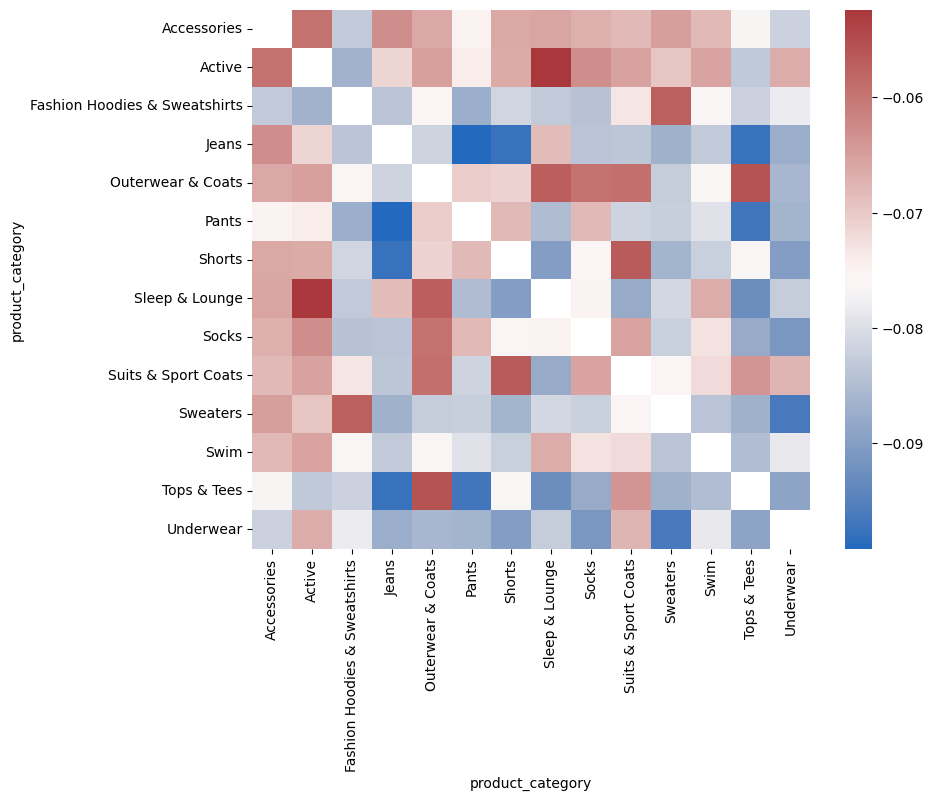

In [65]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_m.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

<Axes: xlabel='product_category', ylabel='product_category'>

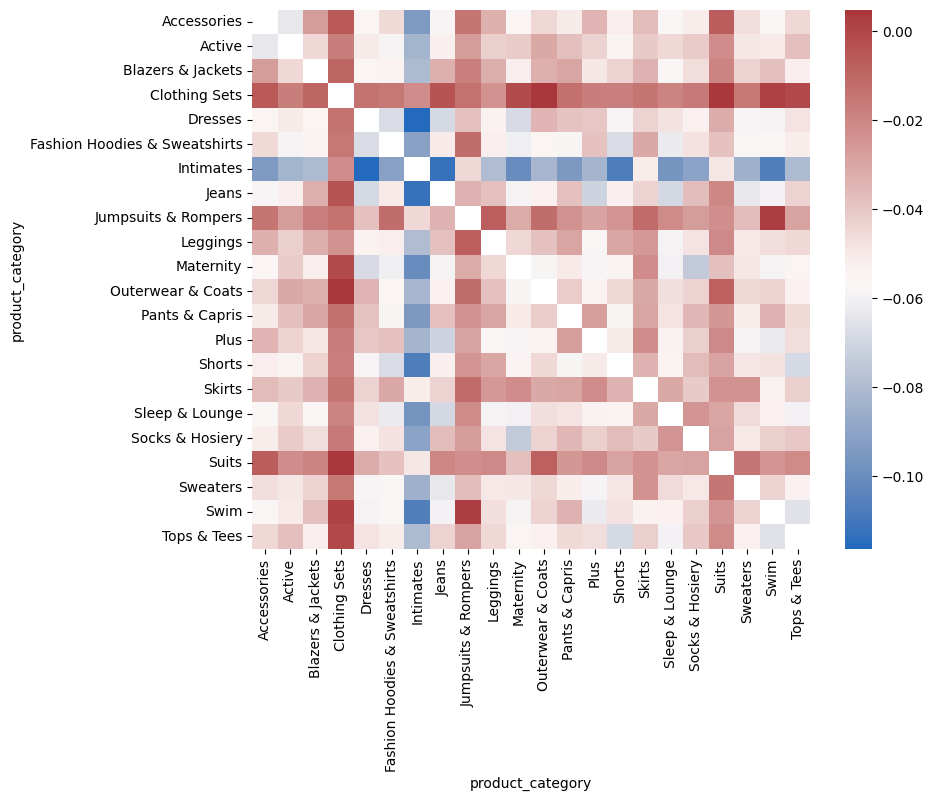

In [66]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_f.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

# Data Preparation

In [67]:
X_cats = X_cats_m

In [68]:
idx = np.arange(X_cats.shape[0])

train_idx, test_idx = train_test_split(idx, test_size=0.1, random_state=RANDOM_STATE)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.1, random_state=RANDOM_STATE)

X_train = X_cats.iloc[train_idx]
X_valid = X_cats.iloc[valid_idx]
X_test = X_cats.iloc[test_idx]

In [69]:
scaler_autoencoder = MinMaxScaler()
X_train_scaled = scaler_autoencoder.fit_transform(X_train)
X_valid_scaled = scaler_autoencoder.transform(X_valid)
X_test_scaled = scaler_autoencoder.transform(X_test)
X_pred_scaled = np.concat([X_train_scaled, X_valid_scaled, X_test_scaled])

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_valid_scaled = torch.tensor(X_valid_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
X_pred_scaled = torch.tensor(X_pred_scaled, dtype=torch.float32)

dataset_train = TensorDataset(X_train_scaled)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

dataset_valid = TensorDataset(X_valid_scaled)
valid_loader = DataLoader(dataset_valid, batch_size=64, shuffle=True)

# Dimensionality Reduction with Autoencoders

In [70]:
ae = AutoEncoder(X_train.shape[1], [12], 4)
ae.encoder, ae.decoder

(Sequential(
   (0): Linear(in_features=14, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=4, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=14, bias=True)
 ))

In [71]:
trainer = AETrainer(ae)
trainer.train(train_loader, valid_loader)

Using device: cpu
Epoch 1/1000, Validation Loss: 0.022828088
Epoch 2/1000, Validation Loss: 0.020416707
Epoch 3/1000, Validation Loss: 0.018637413
Epoch 4/1000, Validation Loss: 0.017108050
Epoch 5/1000, Validation Loss: 0.016400694
Epoch 6/1000, Validation Loss: 0.015890885
Epoch 7/1000, Validation Loss: 0.015177416
Epoch 8/1000, Validation Loss: 0.014557326
Epoch 9/1000, Validation Loss: 0.014261522
Epoch 10/1000, Validation Loss: 0.014096817
Epoch 11/1000, Validation Loss: 0.013767653
Epoch 12/1000, Validation Loss: 0.013602537
Epoch 13/1000, Validation Loss: 0.013586907
Epoch 14/1000, Validation Loss: 0.013248718
Epoch 15/1000, Validation Loss: 0.012963148
Epoch 16/1000, Validation Loss: 0.012937325
Epoch 17/1000, Validation Loss: 0.012547731
Epoch 18/1000, Validation Loss: 0.012315485
Epoch 19/1000, Validation Loss: 0.012142338
Epoch 20/1000, Validation Loss: 0.012045885
Epoch 21/1000, Validation Loss: 0.011819693
Epoch 22/1000, Validation Loss: 0.011577751
Epoch 23/1000, Validati

np.float64(0.009306207191772185)

In [72]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_test_scaled)
test_loss = mse_loss(decoded, X_test_scaled)
test_loss

tensor(0.0089, grad_fn=<MseLossBackward0>)

In [73]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_pred_scaled)
pred_loss = mse_loss(decoded, X_pred_scaled)
pred_loss

tensor(0.0090, grad_fn=<MseLossBackward0>)

In [74]:
X_encoded = encoded.detach().numpy()

In [75]:
X_encoded

array([[ 0.05217429, -0.10785946, -0.16671884, -0.07182629],
       [-0.44089872, -2.0354214 , -0.8309227 ,  1.2487113 ],
       [-0.11658098,  0.06423223,  0.43778116,  0.4710338 ],
       ...,
       [ 0.0395284 ,  0.0877102 , -0.52215743, -0.29722136],
       [-0.28519994, -0.08634579, -0.28343302, -0.24755622],
       [-0.07052615,  0.04743838, -0.2882136 ,  0.19434638]],
      dtype=float32)

In [76]:
pd.DataFrame(X_encoded).describe()

,0,1,2,3
count,8850.000000,8850.000000,8850.000000,8850.000000
mean,-0.354745,-0.133772,-0.370432,0.398681
std,0.434003,0.799042,0.505932,0.370616
min,-1.606375,-3.932047,-1.992231,-0.604994
25%,-0.674821,-0.226707,-0.680588,0.138978
50%,-0.359461,0.085793,-0.340586,0.386234
75%,-0.037444,0.382303,0.023299,0.643610
max,0.576337,1.174318,0.666756,1.737016


# Explaining Encodings with LRP

In [77]:
def make_explanation_df(X, lrp_out, encoded):
    input_np =  X.values
    lrp_np = lrp_out.numpy()
    encoded_np = encoded.detach().numpy()
    data_explain = np.concat([input_np, lrp_np, encoded_np], axis=1)
    
    len_encoding = encoded_np.shape[1]
    input_cols = X.columns.tolist()
    relevance_cols = [f'rel_{col}' for col in input_cols]
    encoding_cols = [f'encoding_{i}' for i in range(len_encoding)]
    explanation_cols = input_cols + relevance_cols + encoding_cols
    columns_map = dict(
        input_cols = input_cols,
        relevance_cols = relevance_cols,
        encoding_cols = encoding_cols
    )
    
    df_explain = pd.DataFrame(data_explain, columns=explanation_cols)
    return df_explain, columns_map

In [78]:
def explanation_corrs(df_explain, columns_map, corr_thresh=0):
    input_cols = columns_map.get('input_cols')
    relevance_cols = columns_map.get('relevance_cols')
    encoding_cols = columns_map.get('encoding_cols')
    
    input_relevance_corr = np.diagonal(df_explain.corr().loc[input_cols, relevance_cols])
    data_input_relevance = {
        'column': input_cols,
        'input_relevance_correlation': input_relevance_corr
    }
    input_relevance_corr = pd.DataFrame(data_input_relevance).sort_values('input_relevance_correlation', ascending=False)
    relevant_columns = input_relevance_corr.loc[input_relevance_corr['input_relevance_correlation']>=corr_thresh, 'column'].sort_values()

    df_explain_corr = df_explain.corr()

    relevance_corr = df_explain_corr.loc[relevant_columns, relevant_columns].values
    relevance_corr = pd.DataFrame(relevance_corr, index=relevant_columns, columns=relevant_columns)
    
    encoding_corr = df_explain_corr.loc[encoding_cols, encoding_cols].values
    encoding_corr = pd.DataFrame(encoding_corr, index=encoding_cols, columns=encoding_cols)
    
    relevance_encoding_corr = df_explain_corr.loc[relevant_columns, encoding_cols].values
    relevance_encoding_corr[(relevance_encoding_corr<corr_thresh)&(relevance_encoding_corr>=0)] = None
    relevance_encoding_corr[(relevance_encoding_corr>-corr_thresh)&(relevance_encoding_corr<0)] = None
    relevance_encoding_corr = pd.DataFrame(relevance_encoding_corr, index=relevant_columns, columns=encoding_cols)

    corr_dfs = dict(
        input_relevance_corr = input_relevance_corr, 
        relevance_corr = relevance_corr,
        encoding_corr = encoding_corr,
        relevance_encoding_corr = relevance_encoding_corr
    )
    
    return corr_dfs

In [79]:
def plot_explanation_corrs(input_relevance_corr, relevance_corr, encoding_corr, relevance_encoding_corr):    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(input_relevance_corr.set_index('column'), cmap='vlag')
    ax.set_title('Input - Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    relevance_corr_copy = relevance_corr.copy()
    m_diag = np.diag(np.diag(np.ones(relevance_corr.shape, np.bool)))
    relevance_corr_copy.values[m_diag] = None
    ax = sns.heatmap(relevance_corr_copy, cmap='vlag')
    ax.set_title('Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(relevance_encoding_corr, cmap='vlag')
    ax.set_title('Relevance - Encoding Correlations')

    fig = plt.figure(figsize=(7, 7))
    encoding_corr_copy = encoding_corr.copy()
    m_diag = np.diag(np.diag(np.ones(encoding_corr_copy.shape, np.bool)))
    encoding_corr_copy.values[m_diag] = None
    ax = sns.heatmap(encoding_corr_copy, cmap='vlag')
    ax.set_title('Encoding Correlations')

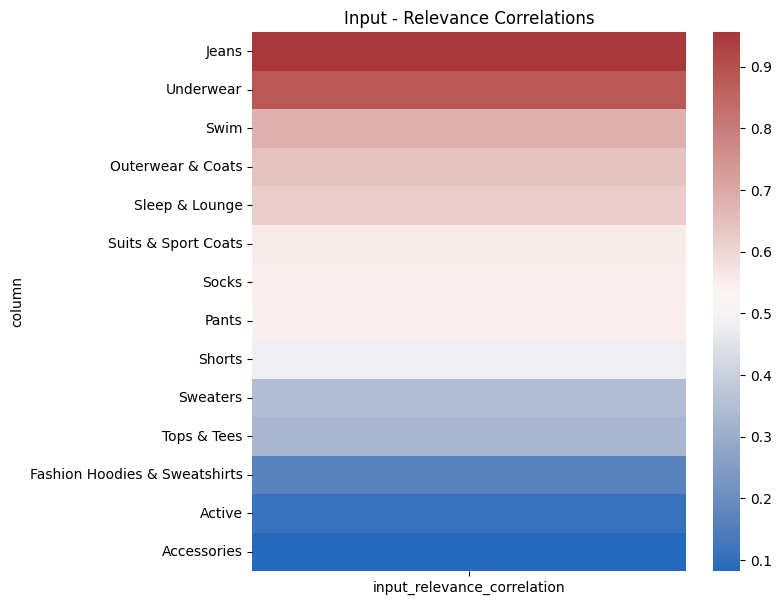

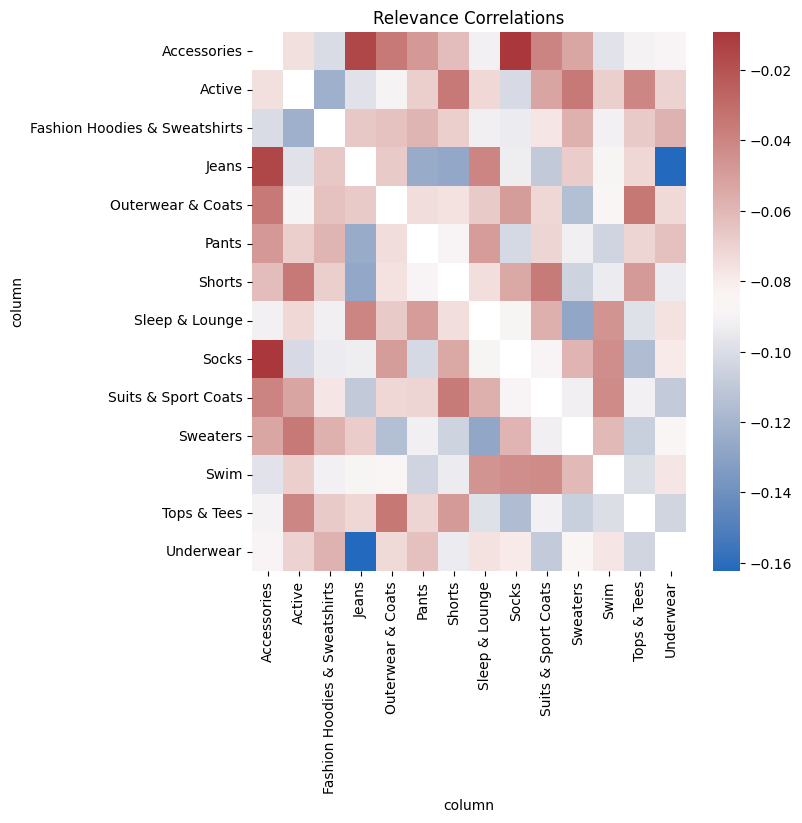

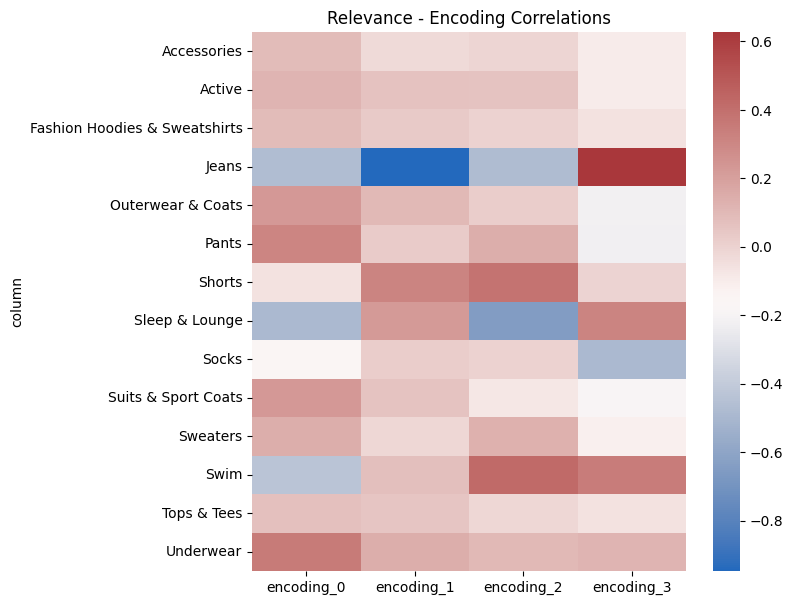

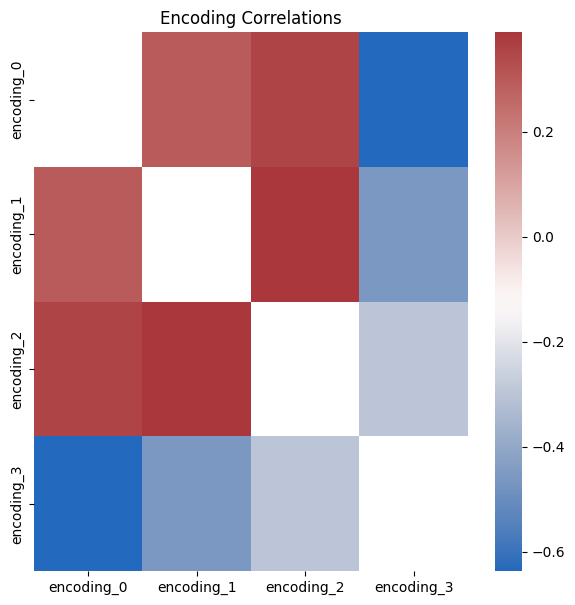

In [82]:
encoded, decoded = ae(X_test_scaled)

lrp = LinearLRP(ae.encoder, top_k=1)
lrp_out = lrp(X_test_scaled)

df_test_scaled = pd.DataFrame(X_test_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_test_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map, corr_thresh=0)
plot_explanation_corrs(**corr_dfs)

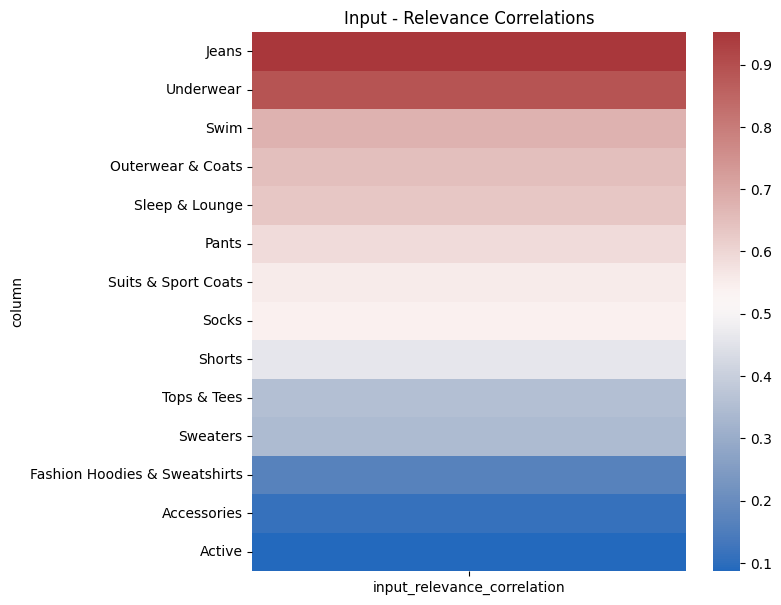

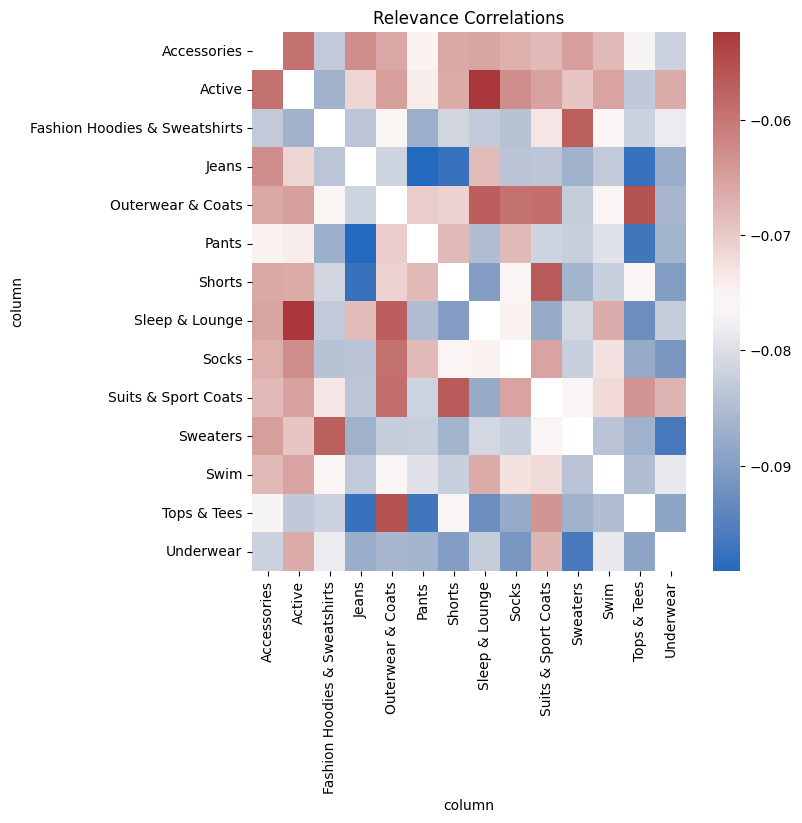

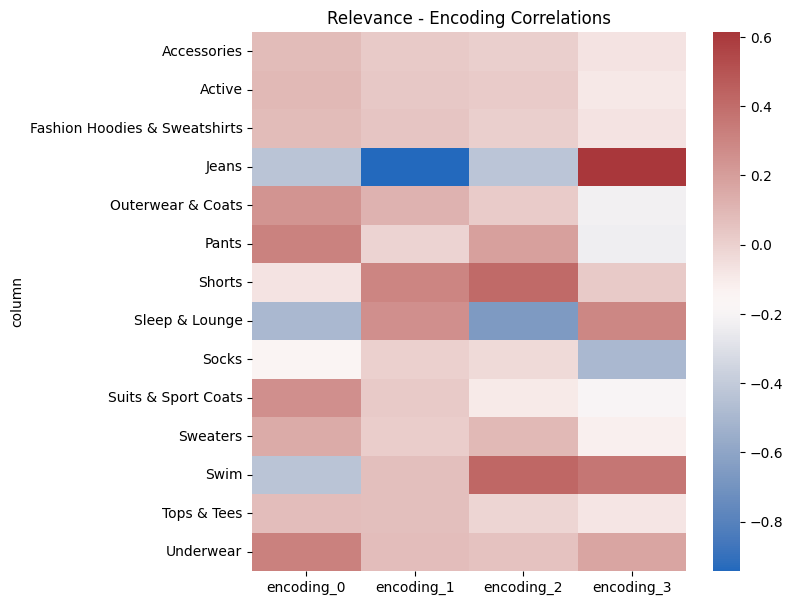

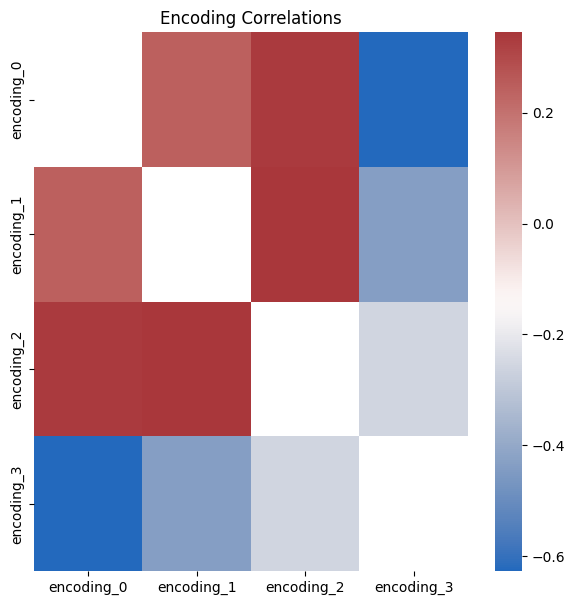

In [84]:
encoded, decoded = ae(X_pred_scaled)

lrp = LinearLRP(ae.encoder, top_k=1)
lrp_out = lrp(X_pred_scaled)

df_pred_scaled = pd.DataFrame(X_pred_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_pred_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map)
plot_explanation_corrs(**corr_dfs)

# Clustering Customers by Encodings

In [85]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        silhouette = silhouette_score(X, y)
        
        if model_type == KMeans:
            error = model.inertia_ 
        else:
            error = None
            
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model,
            'silhouette_score': silhouette,
            'error': error
        }
        
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Error: {error}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [86]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [87]:
scaler_kmeans = MinMaxScaler()
X_scaled = scaler_kmeans.fit_transform(X_encoded)
X_scaled

array([[0.7598573 , 0.74890596, 0.6865443 , 0.22765388],
       [0.533958  , 0.37142384, 0.43674845, 0.791502  ],
       [0.6825428 , 0.7826074 , 0.91388655, 0.4594463 ],
       ...,
       [0.7540636 , 0.78720516, 0.55286986, 0.13141385],
       [0.6052908 , 0.7531191 , 0.64265007, 0.15262005],
       [0.7036426 , 0.7793186 , 0.6408522 , 0.3413053 ]], dtype=float32)

In [88]:
pca_category = PCA(n_components='mle')
X_pca = pca_category.fit_transform(X_encoded)
X_pca

array([[ 0.29450685,  0.4897534 , -0.2771411 ],
       [-2.0663831 ,  0.2651812 ,  0.09390764],
       [ 0.46308494,  0.5232743 ,  0.49665177],
       ...,
       [ 0.41102868,  0.24523139, -0.63073033],
       [ 0.24621016,  0.25966585, -0.2681247 ],
       [ 0.30096835,  0.19762501, -0.17981347]], dtype=float32)

In [89]:
pca_category.explained_variance_ratio_

array([0.6102808 , 0.20452732, 0.14225188], dtype=float32)

In [90]:
X_pca.shape

(8850, 3)

In [91]:
hyperparams = [{'n_clusters': i} for i in range(2, 16)]
kmeans_results = search_clustering_hyperparams(KMeans, hyperparams, X_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.5262771844863892 | Error: 5178.36474609375
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.4506099820137024 | Error: 3636.319091796875
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.46665072441101074 | Error: 2619.860107421875
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4379188120365143 | Error: 2382.10693359375
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.44784530997276306 | Error: 1763.556884765625
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.378897100687027 | Error: 1658.1162109375
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.3748187720775604 | Error: 1506.953857421875
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3762098252773285 | Error: 1325.36376953125
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.39571473002433777 | Error: 1178.070068359375
{'n_clusters': 11, 'random_state': 42} | Silhouette Score: 0.39905

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

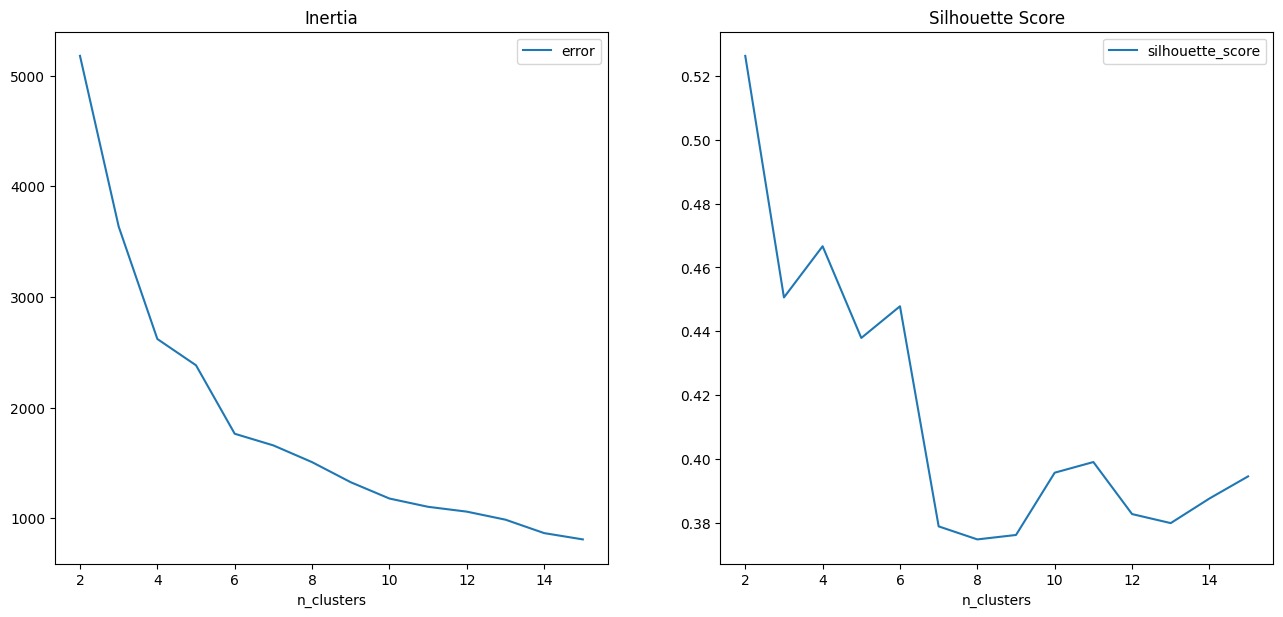

In [92]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)
 
axs[0].set_title('Inertia')
kmeans_results.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [96]:
kmeans = kmeans_results.loc[kmeans_results.n_clusters==4, 'model'].iloc[0]
Xy = pd.DataFrame(X_encoded)
Xy['segment'] = kmeans.labels_

Xy_cats = pd.DataFrame(X_cats_m)
Xy_cats['segment'] = kmeans.labels_

In [97]:
pd.Series(kmeans.labels_).value_counts()

2    3288
3    2264
0    1752
1    1546
Name: count, dtype: int64

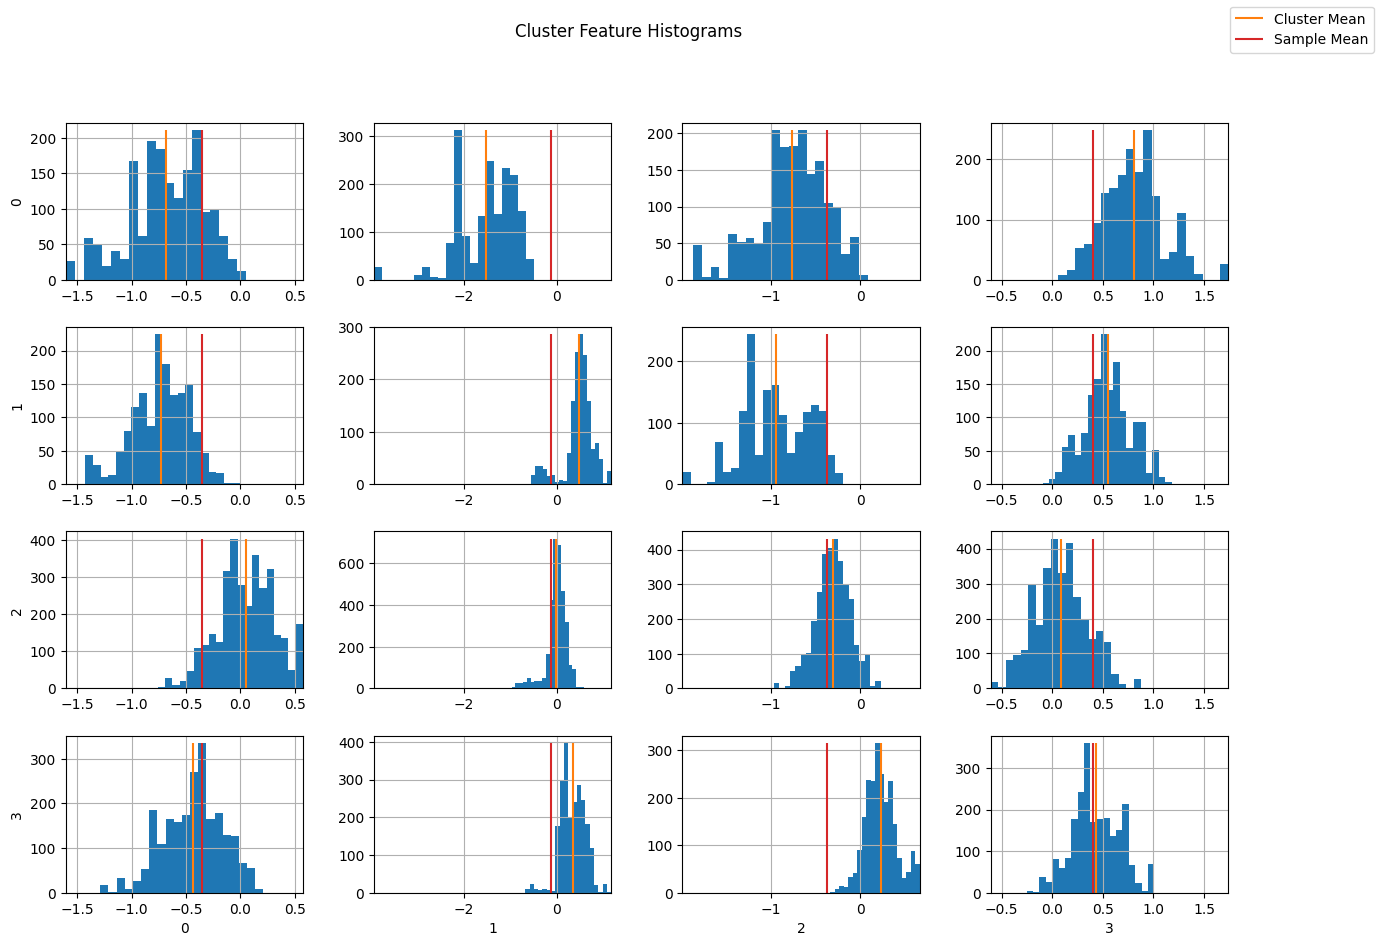

In [98]:
plot_clusters(Xy.drop(columns='segment'), Xy['segment'])

# Profiling Clusters

In [100]:
rel_cols = [col for col in df_explain.columns if col.startswith('rel_')]
X_rel = df_explain[rel_cols]

<Axes: >

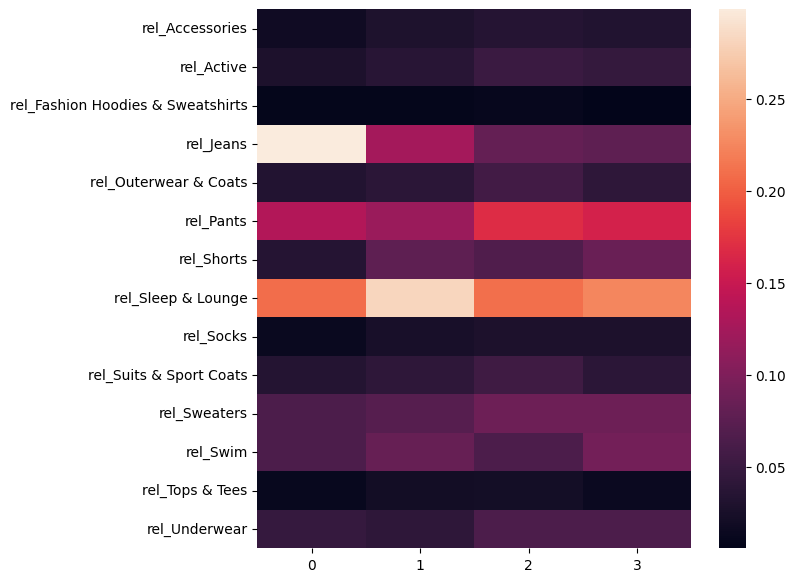

In [101]:
plt.figure(figsize=(7, 7))
sns.heatmap(X_rel.groupby(kmeans.labels_).mean().T)

<Axes: >

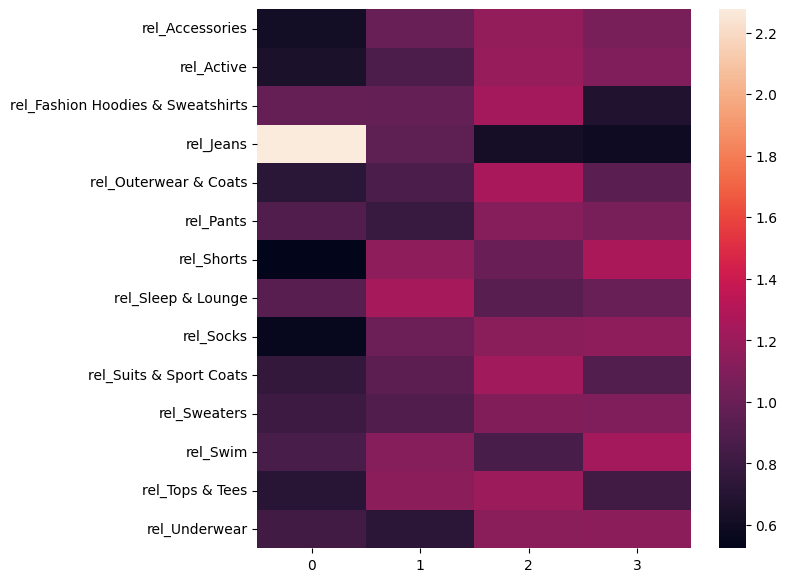

In [102]:
plt.figure(figsize=(7, 7))
sns.heatmap(
    (X_rel.groupby(kmeans.labels_).mean() /
    X_rel.mean()).T
)

<Axes: ylabel='product_category'>

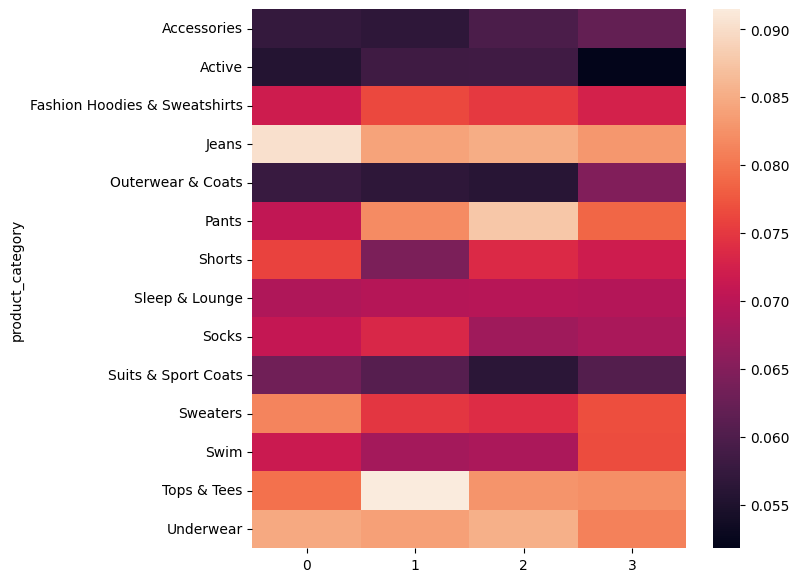

In [104]:
plt.figure(figsize=(7, 7))
sns.heatmap(X_cats.groupby(kmeans.labels_).mean().T)

<Axes: ylabel='product_category'>

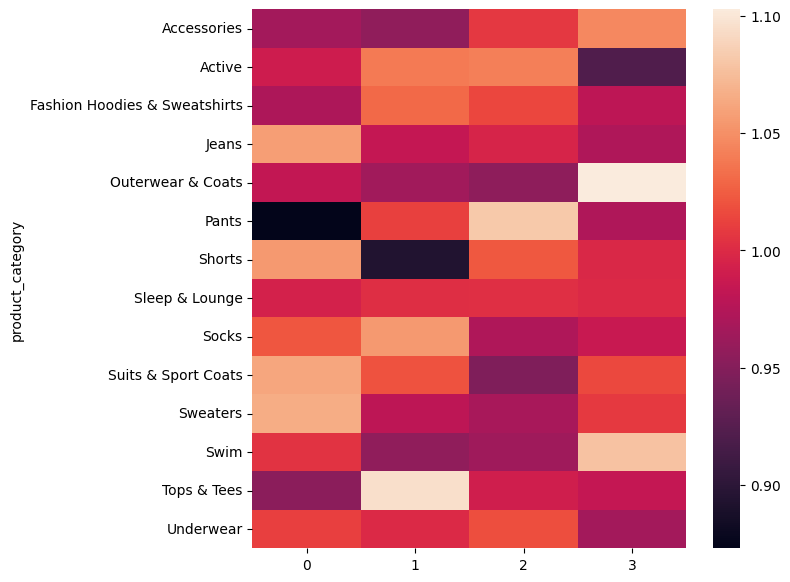

In [105]:
plt.figure(figsize=(7, 7))
sns.heatmap(
    (X_cats.groupby(kmeans.labels_).mean() /
    X_cats.mean()).T
)


Rel. Corr. for Cluster 0:


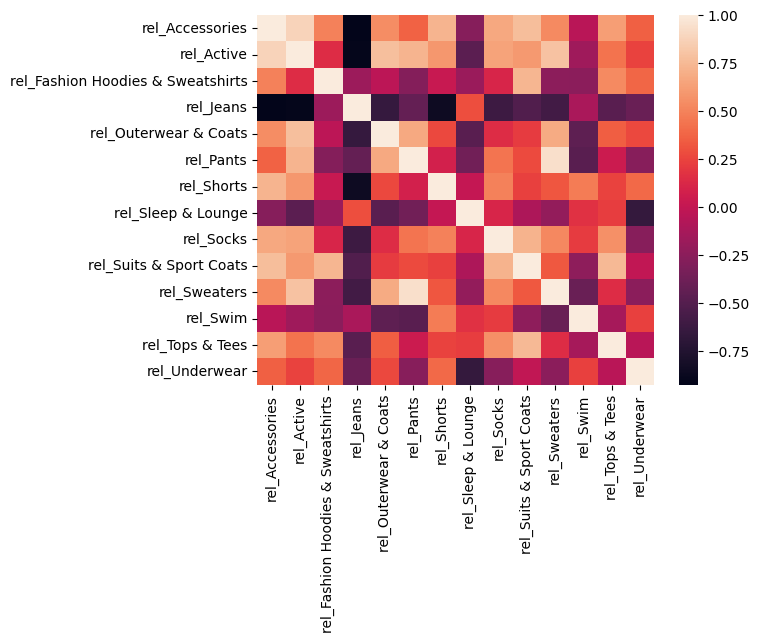


Rel. Corr. for Cluster 1:


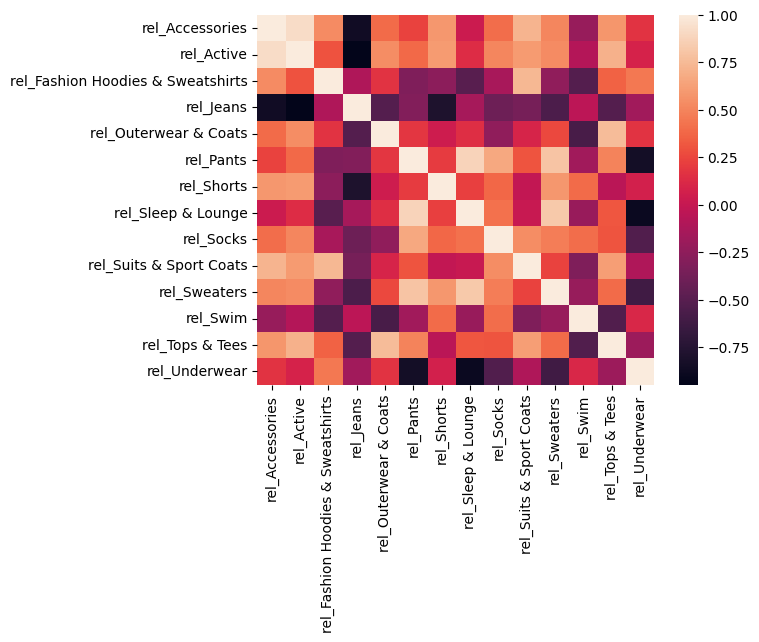


Rel. Corr. for Cluster 2:


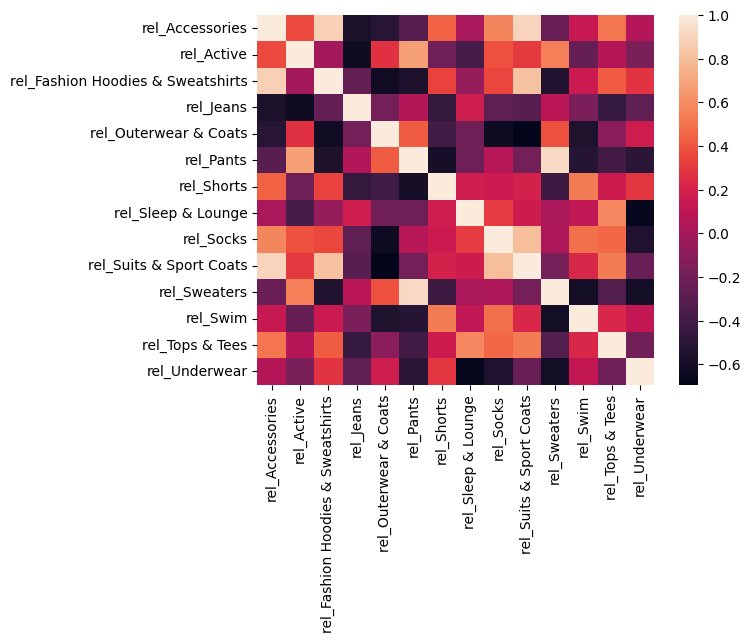


Rel. Corr. for Cluster 3:


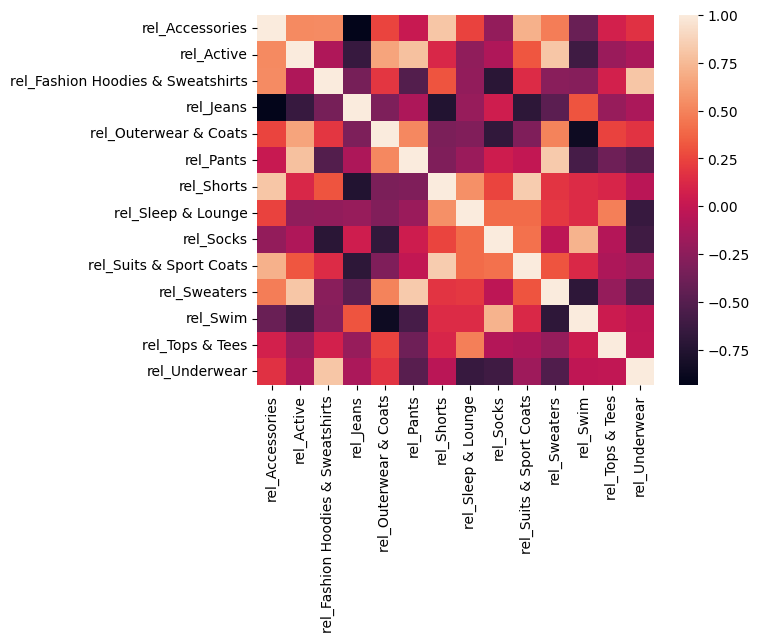

In [109]:
for i in np.unique(kmeans.labels_):
    print(f'\nRel. Corr. for Cluster {i}:')
    cluster_rel_corr = X_rel.loc[kmeans.labels_==i].corr()
    sns.heatmap(cluster_rel_corr)
    plt.show()


Cat. Corr. for Cluster 0:


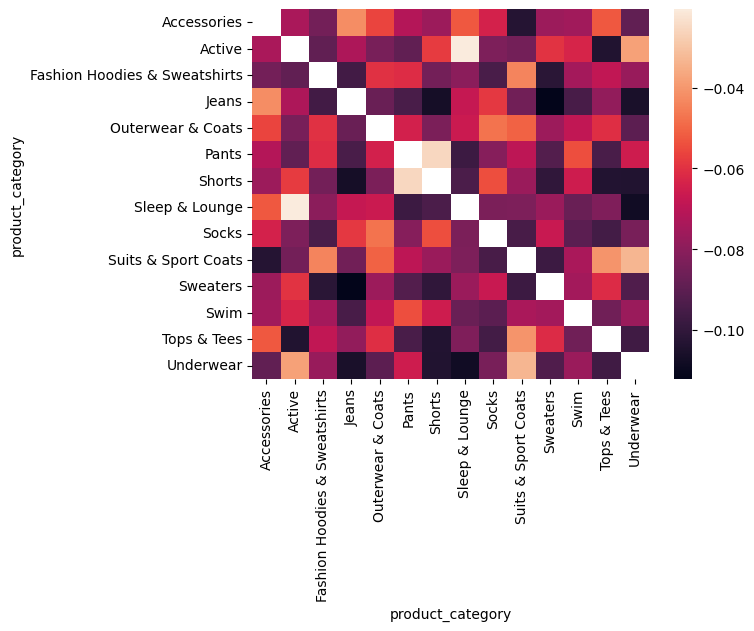


Cat. Corr. for Cluster 1:


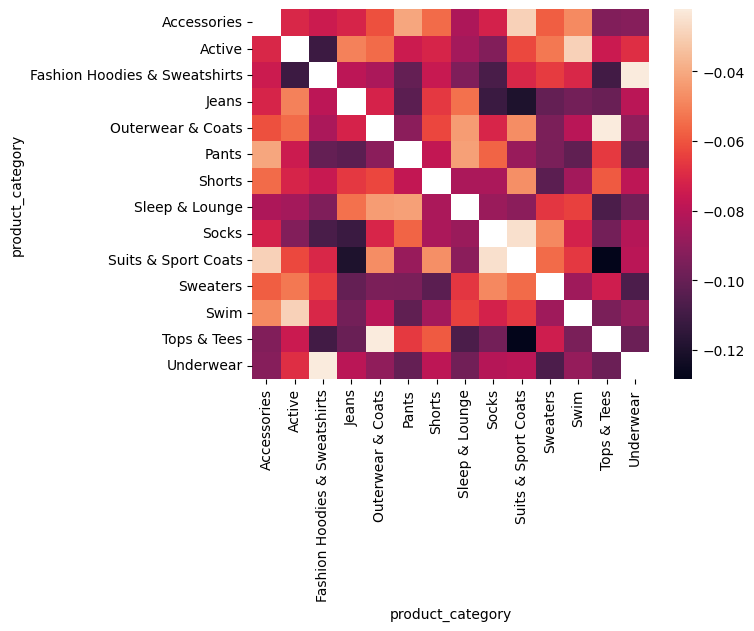


Cat. Corr. for Cluster 2:


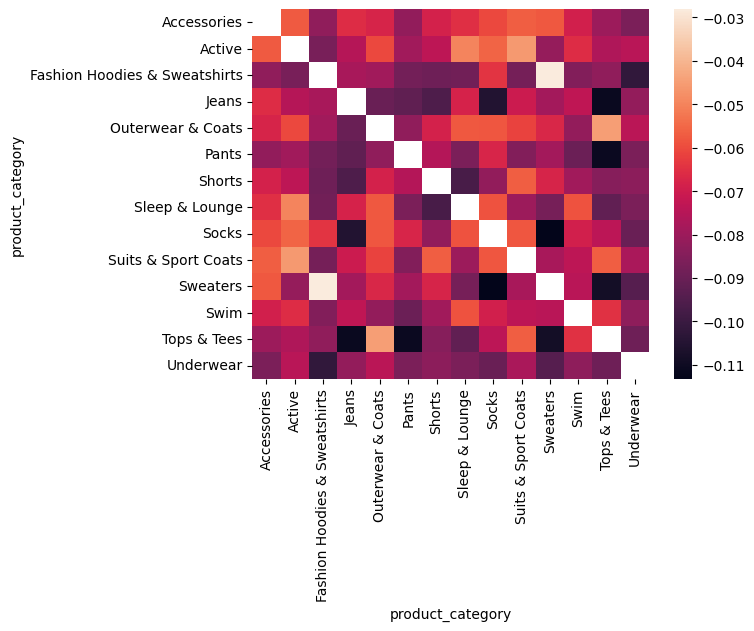


Cat. Corr. for Cluster 3:


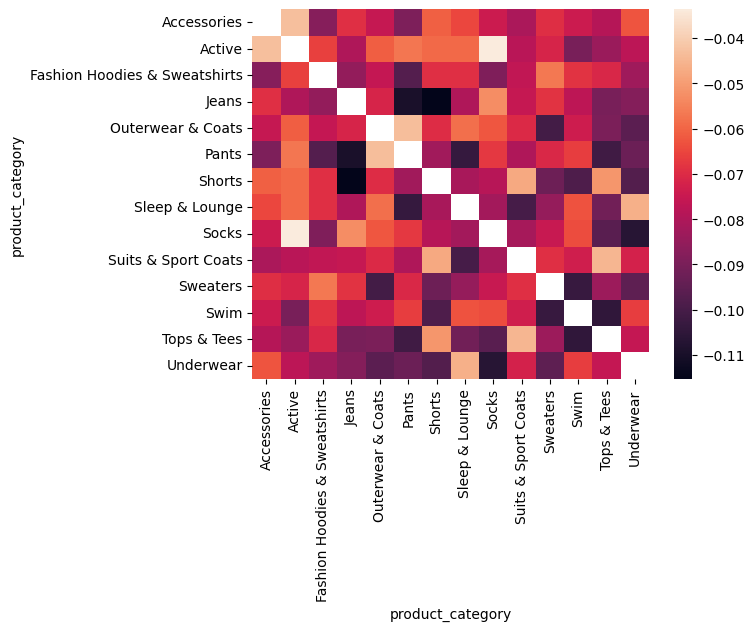

In [112]:
for i in np.unique(kmeans.labels_):
    print(f'\nCat. Corr. for Cluster {i}:')
    cluster_cat_corr = X_cats.loc[kmeans.labels_==i].corr()
    m_diag = np.diag(np.diag(np.ones(cluster_cat_corr.shape, np.bool)))
    cluster_cat_corr.values[m_diag] = None
    sns.heatmap(cluster_cat_corr)
    plt.show()

In [114]:
category_segment_map = {
    0: '',
    1: '',
    2: '',
}

# Saving Pipelines

In [77]:
category_segment_pipe = Pipeline([('scaler', kmeans_scaler), ('kmeans', kmeans)])

NameError: name 'kmeans_scaler' is not defined

In [ ]:
# with open('../models/category_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(category_segment_pipe, f)

In [ ]:
with open('../models/category_segment_pipe.pkl', 'rb') as f:
    category_segment_pipe_loaded = pkl.load(f)

In [ ]:
labels = category_segment_pipe_loaded.predict(X_scaled)
(labels == kmeans.labels_).all()

In [ ]:
with open('../models/category_segment_map.json', 'w') as f:
    json.dump(category_segment_map, f)

In [ ]:
with open('../models/category_segment_map.json', 'r') as f:
    category_segment_map_loaded = json.load(f)

In [ ]:
category_segment_map